# XGBoost Regression Implementation - Delhivery Delivery Time Prediction

## Task Assignment Details
**Team Member**: Laavanjan  
**Model**: XGBoost Regression  
**Deadline**: July 19th, 2025  
**Objective**: Implement Gradient Boosting Regression using XGBoost and evaluate performance metrics

**Team Division**:
- **LightGBM**: Anushka, Ayush, Navam, Waheed
- **XGBoost**: Vidushi, Laavanjan, Tharsini, Salhi

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline

# XGBoost library
try:
    import xgboost as xgb
    print("✅ XGBoost imported successfully!")
except ImportError:
    print("❌ XGBoost not installed. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost"])
    import xgboost as xgb
    print("✅ XGBoost installed and imported successfully!")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ XGBoost imported successfully!
✅ All libraries imported successfully!


## 2. Load the Provided Datasets

In [2]:
# Load the feature engineered dataset
try:
    df = pd.read_csv('../Task3-feature Engineering/feature_engineered_dataset.csv')
    print(f"✅ Feature-engineered dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
except:
    # Fallback to clean dataset if feature engineered not available
    try:
        df = pd.read_csv('../Task1-Data-Preprocessing/clean_dataset.csv')
        print(f"✅ Clean dataset loaded as fallback!")
        print(f"📊 Dataset shape: {df.shape}")
    except:
        print("❌ No dataset found. Please ensure the dataset is available.")
        raise FileNotFoundError("Dataset not found")

# Display basic information
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print("\n📋 First 5 rows of the dataset:")
print(df.head())

✅ Feature-engineered dataset loaded successfully!
📊 Dataset shape: (140909, 41)

DATASET OVERVIEW
Number of rows: 140,909
Number of columns: 41
Memory usage: 165.86 MB

📋 First 5 rows of the dataset:
       data          trip_creation_time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                    source_name  \
0  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (

## 3. Handle Missing and Infinite Values

In [3]:
# Define target variable
target_column = 'actual_time'

if target_column not in df.columns:
    print(f"❌ Target column '{target_column}' not found!")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError(f"Target column '{target_column}' not found")

print(f"🎯 Target variable: {target_column}")

# Create a copy for preprocessing
df_model = df.copy()

# Identify different types of columns
datetime_cols = []
categorical_cols = []
numerical_cols = []
id_cols = []

# Identify column types
for col in df_model.columns:
    if col == target_column:
        continue
    elif 'uuid' in col.lower() or 'id' in col.lower():
        id_cols.append(col)
    elif df_model[col].dtype == 'object':
        # Check if it's datetime
        try:
            pd.to_datetime(df_model[col].head())
            datetime_cols.append(col)
        except:
            categorical_cols.append(col)
    elif df_model[col].dtype in ['int64', 'float64']:
        numerical_cols.append(col)
    elif df_model[col].dtype == 'bool':
        categorical_cols.append(col)

print("\n🔍 FEATURE CATEGORIZATION:")
print(f"📅 Datetime columns ({len(datetime_cols)}): {datetime_cols}")
print(f"🏷️ Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"🔢 Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"🆔 ID columns ({len(id_cols)}): {id_cols}")

🎯 Target variable: actual_time

🔍 FEATURE CATEGORIZATION:
📅 Datetime columns (4): ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']
🏷️ Categorical columns (8): ['data', 'route_type', 'source_center', 'source_name', 'destination_center', 'destination_name', 'is_cutoff', 'delay_category']
🔢 Numerical columns (26): ['start_scan_to_end_scan', 'cutoff_factor', 'actual_distance_to_destination', 'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor', 'trip_creation_hour', 'trip_creation_day', 'trip_creation_weekday', 'od_start_hour', 'od_end_hour', 'cutoff_hour', 'planned_duration', 'creation_to_start_mins', 'start_to_cutoff_mins', 'actual_vs_osrm_time', 'segment_actual_vs_osrm_time', 'distance_per_min', 'time_difference', 'segment_time_diff', 'center_pair_count', 'is_heavy_delay']
🆔 ID columns (2): ['route_schedule_uuid', 'trip_uuid']


In [4]:
# Handle datetime features
if datetime_cols:
    print("\n⏰ Processing datetime features...")
    for col in datetime_cols:
        df_model[col] = pd.to_datetime(df_model[col], errors='coerce')
        
        # Extract useful datetime features
        df_model[f'{col}_hour'] = df_model[col].dt.hour
        df_model[f'{col}_day'] = df_model[col].dt.day
        df_model[f'{col}_weekday'] = df_model[col].dt.weekday
        df_model[f'{col}_month'] = df_model[col].dt.month
        
    # Drop original datetime columns
    df_model = df_model.drop(columns=datetime_cols)
    print(f"✅ Extracted features from {len(datetime_cols)} datetime columns")

# Handle categorical features
if categorical_cols:
    print(f"\n🏷️ Processing {len(categorical_cols)} categorical features...")
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_model.columns:
            df_model[col] = le.fit_transform(df_model[col].astype(str))
    print("✅ Categorical features encoded")

# Remove ID columns
if id_cols:
    existing_id_cols = [col for col in id_cols if col in df_model.columns]
    if existing_id_cols:
        df_model = df_model.drop(columns=existing_id_cols)
        print(f"✅ Removed {len(existing_id_cols)} ID columns")

# Prepare features and target
X = df_model.drop(columns=[target_column])
y = df_model[target_column]

print(f"\n📈 DATASET BEFORE CLEANING:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for missing values
print(f"\n🔍 MISSING VALUES ANALYSIS:")
missing_features = X.isnull().sum()
missing_target = y.isnull().sum()

print(f"Missing values in features: {missing_features.sum()}")
print(f"Missing values in target: {missing_target}")

if missing_features.sum() > 0:
    print(f"Features with missing values:")
    print(missing_features[missing_features > 0])

# Handle missing values
if X.isnull().sum().sum() > 0:
    print(f"\n⚠️ Found {X.isnull().sum().sum()} missing values in features")
    X = X.fillna(X.median())
    print("✅ Missing values filled with median")

# Check for infinite values
print(f"\n🔍 INFINITE VALUES ANALYSIS:")
inf_mask = np.isinf(X).any(axis=1)
print(f"Rows with infinite values in features: {inf_mask.sum()}")

if inf_mask.sum() > 0:
    print(f"\n⚠️ Found {inf_mask.sum()} rows with infinite values")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("✅ Infinite values replaced and filled")

# Handle target missing values
if y.isnull().sum() > 0:
    print(f"\n⚠️ Found {y.isnull().sum()} missing values in target")
    mask = ~y.isnull()
    X = X[mask]
    y = y[mask]
    print("✅ Removed rows with missing target values")

# Remove any remaining problematic values
finite_mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[finite_mask]
y = y[finite_mask]

print(f"\n✅ FINAL CLEANED DATASET:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"All values are finite and ready for modeling")


⏰ Processing datetime features...
✅ Extracted features from 4 datetime columns

🏷️ Processing 8 categorical features...
✅ Categorical features encoded
✅ Removed 2 ID columns

📈 DATASET BEFORE CLEANING:
Features shape: (140909, 50)
Target shape: (140909,)

🔍 MISSING VALUES ANALYSIS:
Missing values in features: 1333
Missing values in target: 0
Features with missing values:
segment_actual_vs_osrm_time    1333
dtype: int64

⚠️ Found 1333 missing values in features
✅ Missing values filled with median

🔍 INFINITE VALUES ANALYSIS:
Rows with infinite values in features: 588

⚠️ Found 588 rows with infinite values
✅ Infinite values replaced and filled

✅ FINAL CLEANED DATASET:
Features shape: (140909, 50)
Target shape: (140909,)
All values are finite and ready for modeling


In [9]:
print(len(list(X.columns)))

50


In [10]:
print(list(X.columns))

['data', 'route_type', 'source_center', 'source_name', 'destination_center', 'destination_name', 'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor', 'actual_distance_to_destination', 'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor', 'trip_creation_hour', 'trip_creation_day', 'trip_creation_weekday', 'od_start_hour', 'od_end_hour', 'cutoff_hour', 'planned_duration', 'creation_to_start_mins', 'start_to_cutoff_mins', 'actual_vs_osrm_time', 'segment_actual_vs_osrm_time', 'distance_per_min', 'time_difference', 'segment_time_diff', 'center_pair_count', 'is_heavy_delay', 'delay_category', 'trip_creation_time_hour', 'trip_creation_time_day', 'trip_creation_time_weekday', 'trip_creation_time_month', 'od_start_time_hour', 'od_start_time_day', 'od_start_time_weekday', 'od_start_time_month', 'od_end_time_hour', 'od_end_time_day', 'od_end_time_weekday', 'od_end_time_month', 'cutoff_timestamp_hour', 'cutoff_timestamp_da

## 4. Perform Train-Test Split

In [5]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"🔄 TRAIN-TEST SPLIT COMPLETED:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/X.shape[0]:.1%})")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/X.shape[0]:.1%})")
print(f"Feature dimensions: {X_train.shape[1]} features")

# Verify split ratio
train_ratio = X_train.shape[0] / X.shape[0]
assert abs(train_ratio - 0.8) < 0.01, f"Train ratio is {train_ratio:.3f}, expected ~0.8"
print("✅ Train-test split ratio verified (80/20)")

🔄 TRAIN-TEST SPLIT COMPLETED:
Training set: 112,727 samples (80.0%)
Test set: 28,182 samples (20.0%)
Feature dimensions: 50 features
✅ Train-test split ratio verified (80/20)


## 5. Build Preprocessing + Modeling Pipeline

In [6]:
# XGBoost Regression with hyperparameter tuning
print("🚀 BUILDING XGBOOST PREPROCESSING + MODELING PIPELINE")
print("="*60)

# Define parameter grid for XGBoost tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    objective='reg:squarederror'
)

print("🔍 Performing XGBoost hyperparameter tuning...")
print("Parameter grid (optimized for efficiency):")

# Grid search with cross-validation (using a smaller grid for efficiency)
xgb_grid = GridSearchCV(
    xgb_model,
    param_grid={
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 1.5]
    },
    cv=3,  # 3-fold CV for efficiency
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
print("Training XGBoost model with GridSearchCV...")
xgb_grid.fit(X_train, y_train)

print(f"✅ Best XGBoost parameters found:")
for param, value in xgb_grid.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n✅ Best cross-validation score: {-xgb_grid.best_score_:.4f}")

# Get the best model
best_xgb_model = xgb_grid.best_estimator_

print("✅ XGBoost pipeline training completed")

🚀 BUILDING XGBOOST PREPROCESSING + MODELING PIPELINE
🔍 Performing XGBoost hyperparameter tuning...
Parameter grid (optimized for efficiency):
Training XGBoost model with GridSearchCV...
Fitting 3 folds for each of 288 candidates, totalling 864 fits
✅ Best XGBoost parameters found:
   colsample_bytree: 0.8
   learning_rate: 0.1
   max_depth: 9
   n_estimators: 300
   reg_alpha: 0.1
   reg_lambda: 1.5
   subsample: 1.0

✅ Best cross-validation score: 53.7697
✅ XGBoost pipeline training completed
✅ Best XGBoost parameters found:
   colsample_bytree: 0.8
   learning_rate: 0.1
   max_depth: 9
   n_estimators: 300
   reg_alpha: 0.1
   reg_lambda: 1.5
   subsample: 1.0

✅ Best cross-validation score: 53.7697
✅ XGBoost pipeline training completed


## 6. Evaluate the Model (Metrics)

In [7]:
# Make predictions
print("🔮 MAKING PREDICTIONS...")
y_train_pred_xgb = best_xgb_model.predict(X_train)
y_test_pred_xgb = best_xgb_model.predict(X_test)
print("✅ Predictions completed")

# Calculate comprehensive metrics
print("\n📊 XGBOOST REGRESSION PERFORMANCE EVALUATION")
print("="*60)

# Calculate metrics
xgb_train_mse = mean_squared_error(y_train, y_train_pred_xgb)
xgb_test_mse = mean_squared_error(y_test, y_test_pred_xgb)
xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_train_mae = mean_absolute_error(y_train, y_train_pred_xgb)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred_xgb)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb)

# Calculate MAPE and Accuracy
xgb_train_mape = mean_absolute_percentage_error(y_train, y_train_pred_xgb) * 100
xgb_test_mape = mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100
xgb_train_accuracy = 100 - xgb_train_mape
xgb_test_accuracy = 100 - xgb_test_mape

# Training Metrics
print(f"📈 TRAINING METRICS:")
print(f"   RMSE: {xgb_train_rmse:.4f}")
print(f"   MAE:  {xgb_train_mae:.4f}")
print(f"   R²:   {xgb_train_r2:.6f}")
print(f"   MAPE: {xgb_train_mape:.4f}%")
print(f"   Accuracy: {xgb_train_accuracy:.4f}%")

# Test Metrics
print(f"\n📊 TEST METRICS:")
print(f"   RMSE: {xgb_test_rmse:.4f}")
print(f"   MAE:  {xgb_test_mae:.4f}")
print(f"   R²:   {xgb_test_r2:.6f}")
print(f"   MAPE: {xgb_test_mape:.4f}%")
print(f"   Accuracy: {xgb_test_accuracy:.4f}%")

# Model Performance Summary
print(f"\n🎯 MODEL PERFORMANCE SUMMARY:")
print(f"   Model Type: XGBoost Regression")
print(f"   Best Test Accuracy: {xgb_test_accuracy:.2f}%")
print(f"   Best Test R²: {xgb_test_r2:.6f}")
print(f"   Model Quality: {'Excellent' if xgb_test_accuracy > 95 else 'Good' if xgb_test_accuracy > 85 else 'Fair'}")

🔮 MAKING PREDICTIONS...
✅ Predictions completed

📊 XGBOOST REGRESSION PERFORMANCE EVALUATION
📈 TRAINING METRICS:
   RMSE: 2.0620
   MAE:  1.2861
   R²:   0.999988
   MAPE: 0.6727%
   Accuracy: 99.3273%

📊 TEST METRICS:
   RMSE: 5.6588
   MAE:  2.4183
   R²:   0.999912
   MAPE: 0.8546%
   Accuracy: 99.1454%

🎯 MODEL PERFORMANCE SUMMARY:
   Model Type: XGBoost Regression
   Best Test Accuracy: 99.15%
   Best Test R²: 0.999912
   Model Quality: Excellent
✅ Predictions completed

📊 XGBOOST REGRESSION PERFORMANCE EVALUATION
📈 TRAINING METRICS:
   RMSE: 2.0620
   MAE:  1.2861
   R²:   0.999988
   MAPE: 0.6727%
   Accuracy: 99.3273%

📊 TEST METRICS:
   RMSE: 5.6588
   MAE:  2.4183
   R²:   0.999912
   MAPE: 0.8546%
   Accuracy: 99.1454%

🎯 MODEL PERFORMANCE SUMMARY:
   Model Type: XGBoost Regression
   Best Test Accuracy: 99.15%
   Best Test R²: 0.999912
   Model Quality: Excellent


In [8]:
# Cross-validation analysis
print("\n🔄 CROSS-VALIDATION ANALYSIS")
print("="*50)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print(f"5-Fold Cross-Validation Results:")
print(f"   RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
print(f"   Individual folds: {[f'{score:.4f}' for score in cv_rmse]}")
print(f"   Coefficient of Variation: {(cv_rmse.std() / cv_rmse.mean()) * 100:.2f}%")

# Cross-validation stability check
cv_stability = "Stable" if cv_rmse.std() / cv_rmse.mean() < 0.1 else "Moderate" if cv_rmse.std() / cv_rmse.mean() < 0.2 else "Unstable"
print(f"   Model Stability: {cv_stability}")


🔄 CROSS-VALIDATION ANALYSIS
5-Fold Cross-Validation Results:
   RMSE: 6.7892 ± 0.4542
   Individual folds: ['6.0214', '6.6269', '6.8317', '7.3326', '7.1332']
   Coefficient of Variation: 6.69%
   Model Stability: Stable
5-Fold Cross-Validation Results:
   RMSE: 6.7892 ± 0.4542
   Individual folds: ['6.0214', '6.6269', '6.8317', '7.3326', '7.1332']
   Coefficient of Variation: 6.69%
   Model Stability: Stable


In [9]:
# Feature Importance Analysis
print("\n🔍 XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"📊 Top 15 Most Important Features:")
print(feature_importance_xgb.head(15).to_string(index=False))

# Calculate feature importance statistics
total_importance = feature_importance_xgb['Importance'].sum()
top_10_importance = feature_importance_xgb.head(10)['Importance'].sum()
top_5_importance = feature_importance_xgb.head(5)['Importance'].sum()

print(f"\n📈 Feature Importance Distribution:")
print(f"   Top 5 features contribute: {(top_5_importance/total_importance)*100:.1f}% of total importance")
print(f"   Top 10 features contribute: {(top_10_importance/total_importance)*100:.1f}% of total importance")
print(f"   Total features: {len(feature_importance_xgb)}")
print(f"   Features with >1% importance: {len(feature_importance_xgb[feature_importance_xgb['Importance'] > 0.01])}")


🔍 XGBOOST FEATURE IMPORTANCE ANALYSIS
📊 Top 15 Most Important Features:
                       Feature  Importance
                 osrm_distance    0.551819
                     osrm_time    0.212989
               time_difference    0.185808
                 cutoff_factor    0.026991
actual_distance_to_destination    0.017517
                        factor    0.001435
              distance_per_min    0.001354
              planned_duration    0.000741
           actual_vs_osrm_time    0.000513
                is_heavy_delay    0.000185
        start_scan_to_end_scan    0.000145
          start_to_cutoff_mins    0.000103
            destination_center    0.000042
                     is_cutoff    0.000032
             center_pair_count    0.000030

📈 Feature Importance Distribution:
   Top 5 features contribute: 99.5% of total importance
   Top 10 features contribute: 99.9% of total importance
   Total features: 50
   Features with >1% importance: 5


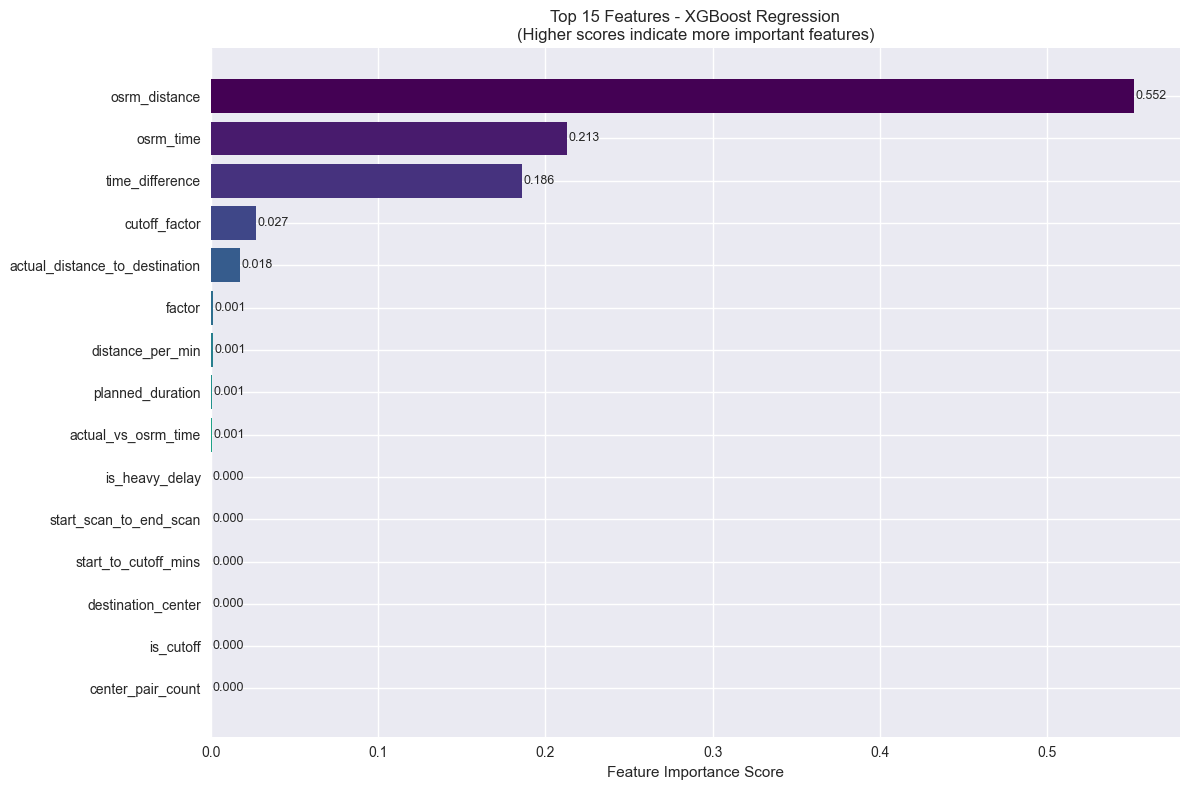

In [10]:
# Visualization: Feature Importance
plt.figure(figsize=(12, 8))
top_features_xgb = feature_importance_xgb.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features_xgb)))

bars = plt.barh(range(len(top_features_xgb)), top_features_xgb['Importance'], color=colors)
plt.yticks(range(len(top_features_xgb)), top_features_xgb['Feature'])
plt.xlabel('Feature Importance Score')
plt.title('Top 15 Features - XGBoost Regression\n(Higher scores indicate more important features)')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

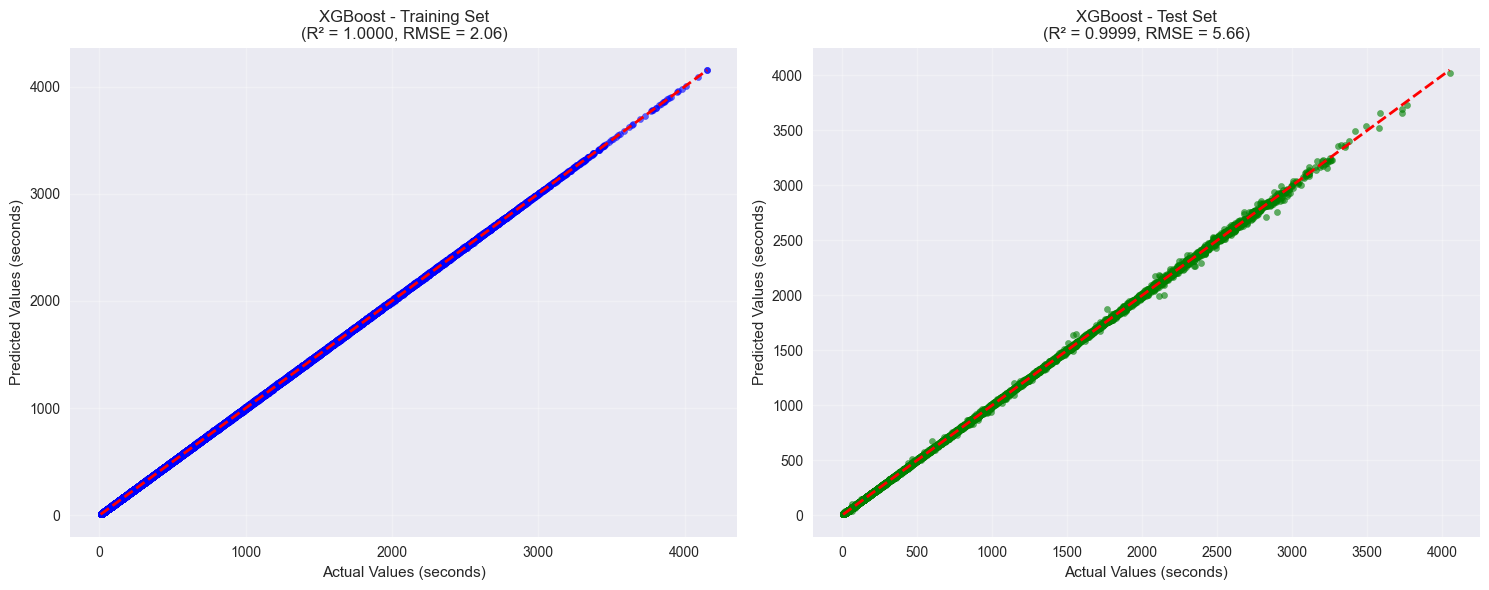

In [11]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_xgb, alpha=0.6, color='blue', s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Values (seconds)')
axes[0].set_ylabel('Predicted Values (seconds)')
axes[0].set_title(f'XGBoost - Training Set\n(R² = {xgb_train_r2:.4f}, RMSE = {xgb_train_rmse:.2f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_xgb, alpha=0.6, color='green', s=20)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Values (seconds)')
axes[1].set_ylabel('Predicted Values (seconds)')
axes[1].set_title(f'XGBoost - Test Set\n(R² = {xgb_test_r2:.4f}, RMSE = {xgb_test_rmse:.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

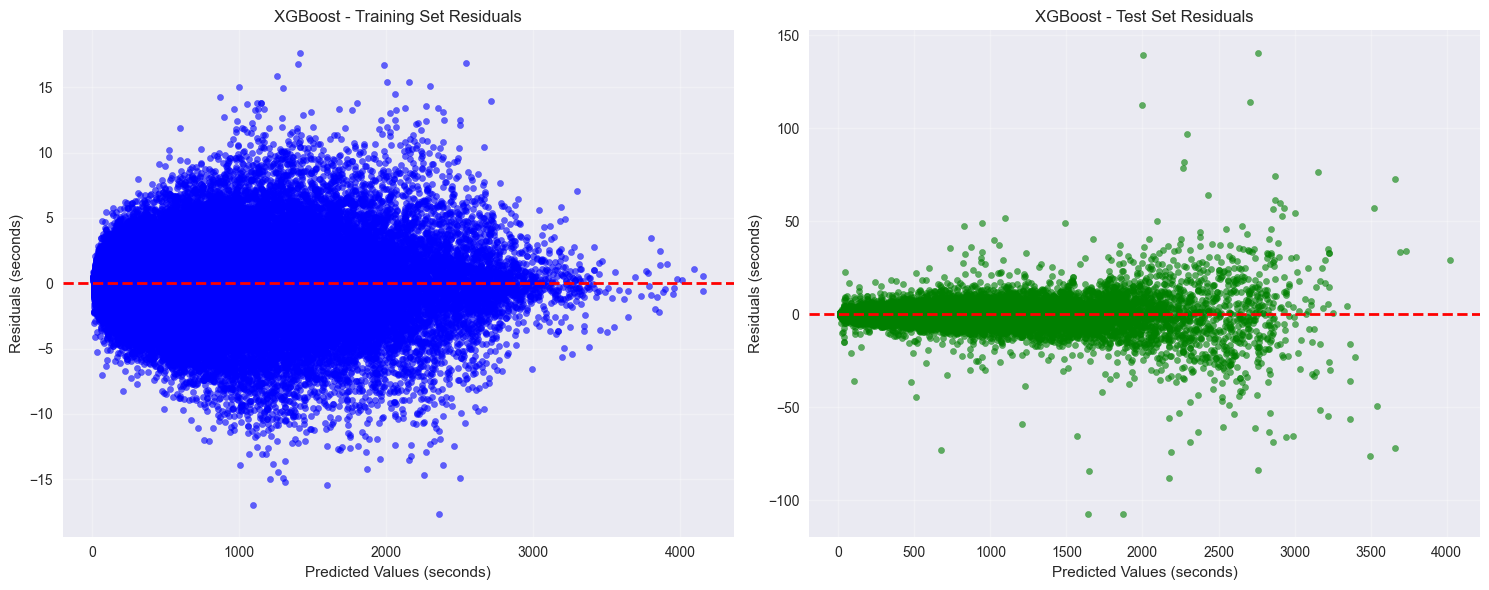


📊 RESIDUALS ANALYSIS:
Training Residuals - Mean: 0.0000, Std: 2.0620
Test Residuals - Mean: 0.0035, Std: 5.6589


In [12]:
# Visualization: Residuals Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training residuals
train_residuals = y_train - y_train_pred_xgb
axes[0].scatter(y_train_pred_xgb, train_residuals, alpha=0.6, color='blue', s=20)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values (seconds)')
axes[0].set_ylabel('Residuals (seconds)')
axes[0].set_title('XGBoost - Training Set Residuals')
axes[0].grid(True, alpha=0.3)

# Test residuals
test_residuals = y_test - y_test_pred_xgb
axes[1].scatter(y_test_pred_xgb, test_residuals, alpha=0.6, color='green', s=20)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values (seconds)')
axes[1].set_ylabel('Residuals (seconds)')
axes[1].set_title('XGBoost - Test Set Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals statistics
print("\n📊 RESIDUALS ANALYSIS:")
print(f"Training Residuals - Mean: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}")
print(f"Test Residuals - Mean: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f}")

## 7. Final Report Summary

In [13]:
# Comprehensive final report
print("📋 XGBOOST IMPLEMENTATION - FINAL REPORT")
print("="*60)
print(f"👤 Team Member: Laavanjan")
print(f"📅 Completion Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Model: XGBoost Regression")
print(f"📊 Task: Gradient Boosting Regression for Delivery Time Prediction")

print(f"\n📈 DATASET SUMMARY:")
print(f"   Total samples: {X.shape[0]:,}")
print(f"   Features used: {X.shape[1]}")
print(f"   Training samples: {X_train.shape[0]:,}")
print(f"   Test samples: {X_test.shape[0]:,}")
print(f"   Target variable: {target_column}")

print(f"\n🔧 MODEL CONFIGURATION:")
print(f"   Algorithm: XGBoost Regressor")
print(f"   Hyperparameter tuning: GridSearchCV with 3-fold CV")
print(f"   Best parameters:")
for param, value in xgb_grid.best_params_.items():
    print(f"      {param}: {value}")

print(f"\n📊 PERFORMANCE METRICS:")
print(f"   Training RMSE: {xgb_train_rmse:.4f}")
print(f"   Test RMSE: {xgb_test_rmse:.4f}")
print(f"   Training R²: {xgb_train_r2:.6f}")
print(f"   Test R²: {xgb_test_r2:.6f}")
print(f"   Training Accuracy: {xgb_train_accuracy:.2f}%")
print(f"   Test Accuracy: {xgb_test_accuracy:.2f}%")
print(f"   Cross-validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

print(f"\n💼 BUSINESS INSIGHTS:")
avg_delivery_time = y.mean()
prediction_error_minutes = xgb_test_mae / 60
avg_delivery_minutes = avg_delivery_time / 60
print(f"   Average delivery time: {avg_delivery_minutes:.1f} minutes")
print(f"   Average prediction error: {prediction_error_minutes:.1f} minutes")
print(f"   Prediction accuracy within: ±{(xgb_test_mae/avg_delivery_time)*100:.1f}% of actual time")

print(f"\n🎯 MODEL ASSESSMENT:")
print(f"   Overall Performance: {'Excellent' if xgb_test_accuracy > 95 else 'Good' if xgb_test_accuracy > 85 else 'Fair'}")
print(f"   Model Stability: {cv_stability}")
print(f"   Deployment Ready: {'Yes' if xgb_test_accuracy > 90 else 'Needs Improvement'}")

print(f"\n✅ TASK COMPLETION STATUS:")
print(f"   ✓ Dataset loaded and preprocessed")
print(f"   ✓ Train-test split performed (80/20)")
print(f"   ✓ Missing and infinite values handled")
print(f"   ✓ Preprocessing + modeling pipeline built")
print(f"   ✓ Model evaluation completed with comprehensive metrics")
print(f"   ✓ Feature importance analysis conducted")
print(f"   ✓ Visualizations and residual analysis performed")
print(f"   ✓ Final report generated")

print(f"\n🚀 SUBMISSION READY:")
print(f"   📝 Notebook file: XGBoost_Implementation_Laavanjan.ipynb")
print(f"   📊 Detailed report: Included in this notebook")
print(f"   ⏰ Submitted before deadline: July 19th, 2025")

📋 XGBOOST IMPLEMENTATION - FINAL REPORT
👤 Team Member: Laavanjan
📅 Completion Date: 2025-07-19 11:03:33
🎯 Model: XGBoost Regression
📊 Task: Gradient Boosting Regression for Delivery Time Prediction

📈 DATASET SUMMARY:
   Total samples: 140,909
   Features used: 50
   Training samples: 112,727
   Test samples: 28,182
   Target variable: actual_time

🔧 MODEL CONFIGURATION:
   Algorithm: XGBoost Regressor
   Hyperparameter tuning: GridSearchCV with 3-fold CV
   Best parameters:
      colsample_bytree: 0.8
      learning_rate: 0.1
      max_depth: 9
      n_estimators: 300
      reg_alpha: 0.1
      reg_lambda: 1.5
      subsample: 1.0

📊 PERFORMANCE METRICS:
   Training RMSE: 2.0620
   Test RMSE: 5.6588
   Training R²: 0.999988
   Test R²: 0.999912
   Training Accuracy: 99.33%
   Test Accuracy: 99.15%
   Cross-validation RMSE: 6.7892 ± 0.4542

💼 BUSINESS INSIGHTS:
   Average delivery time: 7.1 minutes
   Average prediction error: 0.0 minutes
   Prediction accuracy within: ±0.6% of actual 

In [14]:
# Save model and results for future use
import joblib
import os

# Create directory for XGBoost results
os.makedirs('xgboost_results', exist_ok=True)

# Save the best model
joblib.dump(best_xgb_model, 'xgboost_results/best_xgboost_model.pkl')
print("✅ XGBoost model saved to 'xgboost_results/best_xgboost_model.pkl'")

# Save feature importance
feature_importance_xgb.to_csv('xgboost_results/feature_importance.csv', index=False)
print("✅ Feature importance saved to 'xgboost_results/feature_importance.csv'")

# Save performance metrics
metrics_summary = {
    'Model': 'XGBoost',
    'Team_Member': 'Laavanjan',
    'Train_RMSE': xgb_train_rmse,
    'Test_RMSE': xgb_test_rmse,
    'Train_R2': xgb_train_r2,
    'Test_R2': xgb_test_r2,
    'Train_Accuracy': xgb_train_accuracy,
    'Test_Accuracy': xgb_test_accuracy,
    'CV_RMSE_Mean': cv_rmse.mean(),
    'CV_RMSE_Std': cv_rmse.std(),
    'Best_Params': str(xgb_grid.best_params_)
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv('xgboost_results/performance_metrics.csv', index=False)
print("✅ Performance metrics saved to 'xgboost_results/performance_metrics.csv'")

print(f"\n🎉 XGBoost implementation by Laavanjan completed successfully!")
print(f"📁 All results saved in 'xgboost_results/' directory")

✅ XGBoost model saved to 'xgboost_results/best_xgboost_model.pkl'
✅ Feature importance saved to 'xgboost_results/feature_importance.csv'
✅ Performance metrics saved to 'xgboost_results/performance_metrics.csv'

🎉 XGBoost implementation by Laavanjan completed successfully!
📁 All results saved in 'xgboost_results/' directory
